In [1]:
import os
from est_lib.util.obspy_util import *
from est_lib.util.obspy_plot import ray_plot
from obspy import UTCDateTime as dt

In [2]:
test_name = "demo-file-retriever".format(str(dt.now()).replace(':','.'))
folder = 'Demo-Retriever'
writer_path = os.path.join(folder)

In [3]:
# Save
filepath = os.path.abspath(writer_path)

In [4]:
sta_list = [
    'BFSB','CBB','CLRS','HOLB','HOPB','LLLB','NLLB','NTKA','PACB','PHC','PTRF','SNB','SYMB','VGZ','WOSB'
]
cha_list = ['HNE','HNN','HNZ']

In [5]:
inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')

# Mag 6.5
lat = 49.051
lon = -129.8831
time = "2018-10-22T06:22:45"
mag = ('6.5','mww')

sb = 600
sa = 1800

event = (mag[0],lat,lon,time)

streams = stream_retriever(event_time = dt(event[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list,
                          channel_list=cha_list)

In [6]:
# Filter Station List to retain Stations with Trace Data
temp_sta_list = sta_list.copy()
count = 0
with open(os.path.join(filepath,"trace_metadata.txt"),'w') as f:
    for i,sta in enumerate(temp_sta_list):
        score = 0
        for j,cha in enumerate(cha_list):
            temp = streams.select(station=sta,channel=cha)
            try:
                #print(sta+'-'+cha)
                f.write('{}\n'.format(temp[0]))
                count+=1
            except(IndexError):
                score+=1
        if score > 0:
            sta_list.remove(sta)

print("Count = {}".format(count))
print(sta_list)
print(len(sta_list))

Count = 33
['BFSB', 'CBB', 'HOLB', 'HOPB', 'NLLB', 'PACB', 'PHC', 'PTRF', 'SNB', 'SYMB', 'VGZ']
11


In [7]:
streams.filter(type='bandpass',freqmin=0.01,freqmax=4)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [8]:
streams.remove_response(inventory=inv)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [9]:
# Visualize
plot_stream = streams.select()
plot_stream

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

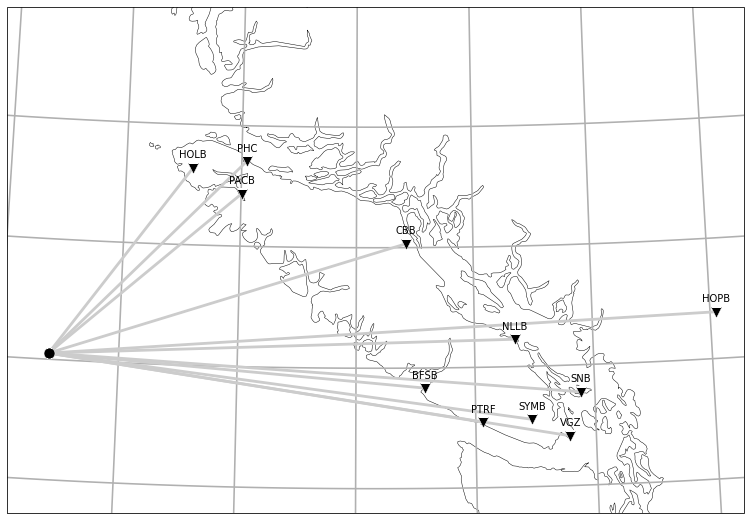

In [10]:
ev_fig = ray_plot(
    ev_lat=lat,
    ev_lon=lon,
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=streams,
    inventory=inv)

In [11]:
# Metadata Printer
def dump_meta(inv,sta_list,f_path):
    with open(f_path,'w') as f:
        f.write("Station\t\tLatitude\tLongitude\n")
        f.write("=======\t\t========\t=========")
        for sta in sta_list:
            temp = inv.select(station=sta)
            station = temp[0][0]
            f.write("\n{}\t\t{}\t\t{}".format(station.code,station.latitude,station.longitude))
        f.write("\n")
            
def dump_event_meta(ev,sb,sa,f_path):
    start = str(dt(ev[3])-sb)
    end = str(dt(start)+sa)
    with open(f_path,'w') as f:
        f.write("Magnitude\tLatitude\tLongitude\tTrace-Start (UTC)\t\tTrace-End (UTC)\n")
        f.write("==========\t========\t=========\t=================\t\t===============\n")
        f.write("{}\t\t{}\t\t{}\t{}\t{}".format(ev[0],ev[1],ev[2],start,end))
        f.write("\n")

In [12]:
dump_meta(inv,sta_list,os.path.join(filepath,'station_metadata.txt'))
with open(os.path.join(filepath,'station_metadata.txt'),'r') as f:
    print(f.read())

Station		Latitude	Longitude
=======		========	=========
BFSB		48.8336		-125.136
CBB		50.0315		-125.3652
HOLB		50.6402		-128.1331
HOPB		49.3872		-121.4206
NLLB		49.2271		-123.9882
PACB		50.4355		-127.4925
PHC		50.7067		-127.433
PTRF		48.5442		-124.4131
SNB		48.7751		-123.1723
SYMB		48.5593		-123.7989
VGZ		48.4131		-123.3251



In [13]:
dump_event_meta(event,sb,sa,os.path.join(filepath,'event_metadata.txt'))
with open(os.path.join(filepath,'event_metadata.txt'),'r') as f:
    print(f.read())

Magnitude	Latitude	Longitude	Trace-Start (UTC)		Trace-End (UTC)
==========	========	=========	=================		===============
6.5		49.051		-129.8831	2018-10-22T06:12:45.000000Z	2018-10-22T06:42:45.000000Z



In [14]:
trace_file = stream_data_writer(streams,
                              inv,
                              os.path.join(filepath,'time_series_accelleration_data.npy'),
                              sta_list,
                              cha_list)

In [15]:
samp = stream_data_reader(os.path.join(filepath,'time_series_accelleration_data.npy'))
print(samp.shape)

(180001, 11, 3)


In [20]:
# Check if Data is Packed Correctly
for i,sta in enumerate(sta_list):
    for j,cha in enumerate(cha_list):
        temp = streams.select(station=sta,channel=cha)
        assert np.all(np.equal(temp[0].data,samp[:,i,j]))

In [17]:
import matplotlib.pyplot as plt

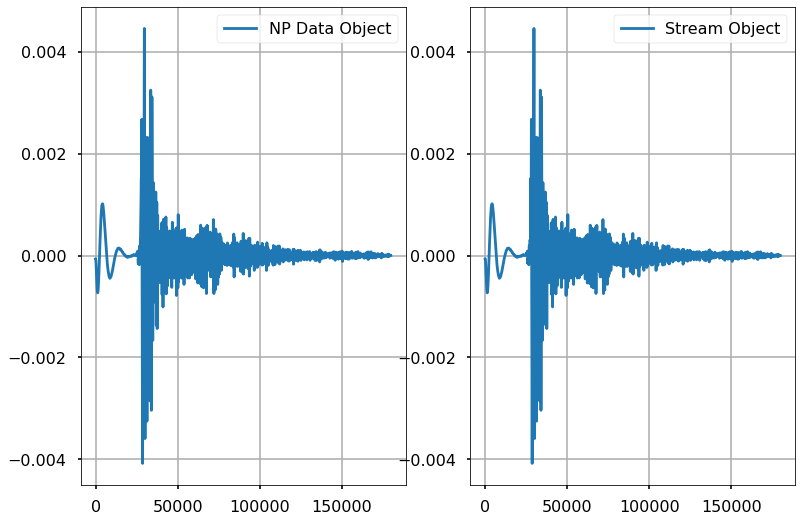

In [18]:
# Plot to Verify
# 7th Stream (2,0) --> CN.HOPB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples
plt.figure()
plt.subplot(1,2,1)
plt.plot(samp[:,2,0],label='NP Data Object')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(streams[6],label='Stream Object')
plt.legend()
plt.grid()
plt.show()